In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt

In [3]:
psr_choice = 'B1919+21'  # pretend that the user has specified this pulsar name
freq_choice = 2000 # pretend that the user has specified they want data close to 1400 MHz

In [4]:
url = 'https://psrweb.jb.man.ac.uk/epndb/list.php'   # list of links

In [5]:
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
links = soup.find_all('a')
site_text = soup.get_text(separator=' ', strip=True)

# get the text from the web page

In [6]:
# make two lists:
# href_list is the page that is hyperlinked
# text_list is the text associated with the same hyperlink

href_list = []
text_list = []

for link in links:
    href_url = link.get('href')
    href_text = link.get_text(strip=True)
    href_list.append(href_url)
    text_list.append(href_text)

In [7]:
# get the text on the webpage that is not associated with a hyperlink, as this has the pulsars names

non_hyperlink_text = []

for element in soup.find_all(string=True):
    if element.parent.name != 'a':  # Exclude text within <a> tags
        non_hyperlink_text.append(element.strip())

In [8]:
# clean up non_hyperlink_text to make a list where each entry is the pulsar J2000 name (if it only has that name), 
# or the J2000 name and B1950 name (if it has both of those names)

psrnames = []

for i in range(0,len(non_hyperlink_text)):
    if non_hyperlink_text[i].startswith('J'):
        Jname = non_hyperlink_text[i].split(' ')[0]  # Get everything before the first space
        if non_hyperlink_text[i+1].startswith('(B'):   
            Bname = non_hyperlink_text[i+1].split(' ')[0]
            Bname = Bname.replace('(', '').replace(')', '')
            psrnames.append(str(Jname+" "+Bname))
        else:
            psrnames.append(Jname)


In [9]:
# some pulsars have both a J name and a B name. Data is listed under the J name.
# if the user has supplied a B name, find its J name and change the choice of name to that one

if psr_choice[0] == 'B':
    Bname=psr_choice
    for index, entry in enumerate(psrnames):
        if psr_choice in entry:
            break
    psr_choice=psrnames[index].split(' ')[0]
    Jname = psr_choice

In [10]:
# search the hyperlinks and return a list of the indices where data for this pulsar is found

psr_indices = []

for index, entry in enumerate(href_list):
    if psr_choice in entry:
        psr_indices.append(index)

In [12]:
# finds the list index of the file for the chosen pulsar that is closest to the user's choice of observing frequency

closest_index = min(
    psr_indices, 
    key=lambda i: abs(float(text_list[i].split(' ')[0]) - freq_choice)
)

In [13]:
# construct the URL path to the ascii data for this pulsar and observing freq

url_to_ascii = "https://psrweb.jb.man.ac.uk/epndb/ascii"+href_list[closest_index].replace('#', '/').replace('epn', 'txt')

In [14]:
# grab the raw data from the web

init_psrdata = requests.get(url_to_ascii).text.splitlines()

In [15]:
# sometimes pulsars might be listed under their J name or B name. If the data can't be grabbed, try constructing the URL with the other name

try:
    response = requests.get(url_to_ascii)
    response.raise_for_status()  # Will raise an HTTPError for bad responses
except requests.exceptions.RequestException as e:
    if psr_choice[0] == 'J':
        url_to_ascii = url_to_ascii.replace(Jname, Bname)
        
init_psrdata = requests.get(url_to_ascii).text.splitlines()

In [16]:
# get just the total intensity data

psrdata_list = []

for i in range(0,len(init_psrdata)):    
    psrdata_list.append(float(init_psrdata[i].split()[3]))

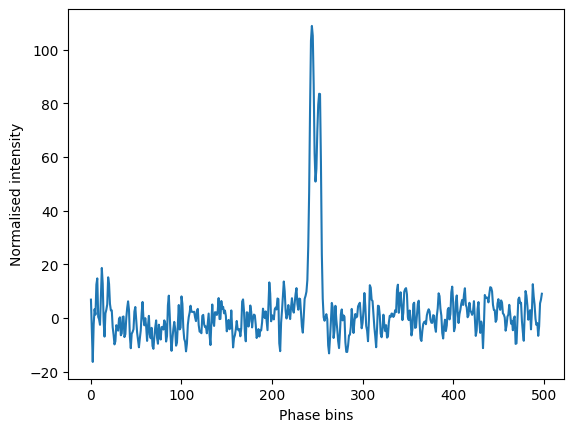

In [17]:
# plot it!

plt.plot(psrdata_list)
plt.ylabel("Normalised intensity")
plt.xlabel("Phase bins")
plt.show()